# Part 1 — Modèle de détection de mail/message frauduleux (Phishing)

Objectif:
- Entraîner un modèle de classification (phishing vs safe) sur des données textuelles
- Évaluer les performances (Precision/Recall/F1, etc.)
- Sauvegarder les artifacts (vectorizer + model)
- Générer `ref_data.csv` (données de référence vectorisées) pour la suite (monitoring / drift / retrain)


In [108]:
# Imports & configuration
import os
import re
import json
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    f1_score, precision_score, recall_score,
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score,
    roc_auc_score, roc_curve, auc
)

RANDOM_SEED = 42

DATA_PATH = "../data/Phishing_Email.csv"

# Output path:
ARTIFACT_DIR = "../artifacts"
DATA_OUT_DIR = "../data"
os.makedirs(ARTIFACT_DIR, exist_ok=True)
os.makedirs(DATA_OUT_DIR, exist_ok=True)

print("OK: dirs ready")


OK: dirs ready


In [109]:
# Lecture des données et vérification rapide
df = pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head())

print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())

# Distribution d'étiquettes
print("\nLabel distribution:\n", df["Email Type"].value_counts())

(18650, 3)


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email



Columns: ['Unnamed: 0', 'Email Text', 'Email Type']

Missing values:
 Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

Label distribution:
 Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64


## Présentation du jeu de données — Détection de phishing (emails)
Link dataset: https://www.kaggle.com/datasets/subhajournal/phishingemails  
### Objectif
Ce jeu de données sert à entraîner un modèle de **classification binaire** pour détecter si un email est :
- **Safe Email** (légitime)
- **Phishing Email** (frauduleux)

L’objectif est d’utiliser le **contenu textuel** des emails pour prédire automatiquement la classe.

---

### Fichier utilisé
- **Nom** : `Phishing_Email.csv`
- **Taille** : **18 650** emails

---

### Structure des données
Le fichier contient **3 colonnes** :
- `Unnamed: 0` : index (colonne technique, non utile pour l’apprentissage)
- `Email Text` : texte brut de l’email (feature principale)
- `Email Type` : étiquette cible (`Safe Email` ou `Phishing Email`)

---

### Qualité des données
- Valeurs manquantes :
  - `Email Text` : **16** valeurs manquantes
  - `Email Type` : **0** valeur manquante
- Les textes sont déjà au format exploitable, mais nécessitent un **nettoyage minimal** (ex. suppression des NaN, normalisation).

---

### Distribution des classes (déséquilibre modéré)
- **Safe Email** : **11 322**
- **Phishing Email** : **7 328**

Le dataset n’est pas parfaitement équilibré, donc on pourra utiliser :
- `class_weight="balanced"` (dans un modèle linéaire)  
ou
- des métriques adaptées (F1-score, balanced accuracy, recall phishing, etc.)

---

### Utilisation dans le projet MLOps
Ce jeu de données sera utilisé pour :
1. Entraîner et évaluer un modèle de détection de phishing (TF-IDF + modèle de classification)
2. Sauvegarder les artifacts (vectorizer + modèle)
3. Générer `ref_data.csv` (données vectorisées de référence) pour le monitoring, la détection de drift et le ré-entraînement


In [110]:
# Nettoyage de base (normalisation du texte + mapping des labels)

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower().strip()
    # fusionner les espaces multiples
    s = re.sub(r"\s+", " ", s)
    return s

# -----------------------------
# Nettoyage structurel
# -----------------------------
# Supprimer colonne index inutile
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Supprimer les textes manquants
df = df.dropna(subset=["Email Text"]).reset_index(drop=True)

# Limiter la longueur des emails (stabilité + performance)!!
MAX_LEN = 10000
df["Email Text"] = df["Email Text"].astype(str).str.slice(0, MAX_LEN)

# -----------------------------
# Renommage des colonnes
# -----------------------------
df = df.rename(columns={
    "Email Text": "text",
    "Email Type": "label_str"
})

# Normalisation du texte
df["text"] = df["text"].apply(normalize_text)
  
# -----------------------------
# Déduplication des emails strictement identiques
# -----------------------------
before = len(df)

df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

after = len(df)
removed = before - after

print(f"Deduplication: {before} → {after} lignes")
print(f"Nombre de doublons supprimés: {removed}")

# -----------------------------
# Mapping des labels
# -----------------------------
label_map = {
    "Phishing Email": 1,
    "Safe Email": 0,
}

df["label"] = df["label_str"].map(label_map)

# Vérification des labels non mappés
bad = df[df["label"].isna()]
print("Unmapped labels rows:", len(bad))
if len(bad) > 0:
    display(bad.head())

df["label"] = df["label"].astype(int)

display(df.head())


Deduplication: 18634 → 17504 lignes
Nombre de doublons supprimés: 1130
Unmapped labels rows: 0


,text,label_str,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,the other side of * galicismos * * galicismo *...,Safe Email,0
2,re : equistar deal tickets are you still avail...,Safe Email,0
3,hello i am your hot lil horny toy. i am the on...,Phishing Email,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,1


## Séparation des données en Train / Validation / Test (70% / 15% / 15%)
- **Train** : utilisé pour entraîner le modèle  

- **Validation** : utilisé pour l’ajustement des hyperparamètres, la sélection du modèle et l’arrêt anticipé (*early stopping*)  

- **Test** : utilisé uniquement à la toute fin pour évaluer la capacité réelle de généralisation du modèle  


In [111]:
# Séparation des données en Train / Validation / Test (70% / 15% / 15%)

X = df["text"].values      # Textes des emails (features)
y = df["label"].values     # Labels numériques (0 = safe, 1 = phishing)

# Première séparation : 70% entraînement, 30% temporaire (validation + test)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X,
    y,
    test_size=0.30,              # 30% pour validation + test
    random_state=RANDOM_SEED, 
    stratify=y                   # Conserver la proportion des classes
)

# Deuxième séparation : 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    test_size=0.50,              # Diviser le 30% en deux parties égales
    random_state=RANDOM_SEED,
    stratify=y_tmp               # Même distribution des labels
)

# Affichage des tailles des ensembles
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 12252 Val: 2626 Test: 2626


## Modèles baseline — Comparaison équitable (TF-IDF + classifieurs linéaires)

Cette section met en place une **comparaison contrôlée et équitable** entre deux modèles de référence
couramment utilisés en classification de texte :

- **TF-IDF + Régression Logistique (LR)**
- **TF-IDF + Linear SVM (LinearSVC)**

### Objectif
- Évaluer l’impact du **classifieur** à caractéristiques identiques
- Vérifier si un modèle linéaire à marge (SVM) apporte un gain par rapport à la LR
- Fournir un **baseline robuste, rapide et interprétable** pour la détection de phishing

### Méthodologie
- Utilisation d’une **configuration TF-IDF commune** (unigrammes + bigrammes)
- Pondération des classes pour gérer le déséquilibre
- Entraînement et évaluation sur le même jeu de validation
- Mesures utilisées :
  - **Precision**, **Recall**, **F1-score**
  - **ROC-AUC** (probabilités pour LR, scores de décision pour SVM)
  - Temps d’entraînement et de prédiction

### Résultats
- Les performances sont comparées à la fois en **qualité de classification** et en **coût de calcul**
- Les visualisations permettent d’identifier rapidement le meilleur compromis
  entre efficacité, rappel (critique en phishing) et rapidité

 Ces modèles servent de **référence de départ** pour juger la pertinence de modèles plus complexes.


LR        | F1=0.971 P=0.964 R=0.979 AUC=0.996 | fit=8.117s pred=1.0019s
LinearSVC | F1=0.979 P=0.977 R=0.981 AUC=0.998 | fit=8.634s pred=1.0736s


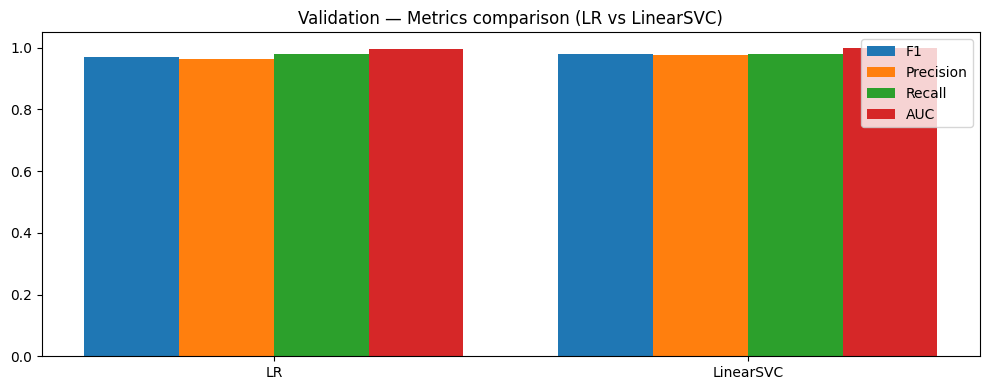

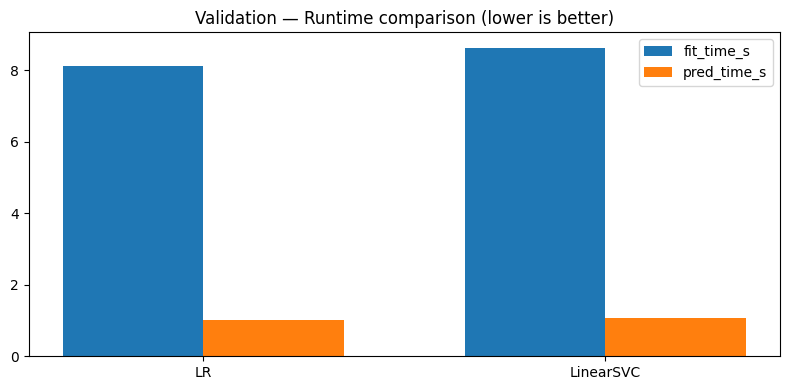

In [112]:
# -----------------------------
# 0) Common TF-IDF config (Maintenir la cohérence, garantir une comparaison équitable)
# -----------------------------
tfidf_cfg = dict(
    ngram_range=(1, 2),
    min_df=2
    # Removed max_features=30000 to use actual vocabulary size from data
)

# -----------------------------
# 1) Models
# -----------------------------
models = {
    "LR": Pipeline([
        ("tfidf", TfidfVectorizer(**tfidf_cfg)),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=RANDOM_SEED,
            solver="liblinear"   # La classification binaire + caractéristiques clairsemées est assez stable.
        ))
    ]),
    "LinearSVC": Pipeline([
        ("tfidf", TfidfVectorizer(**tfidf_cfg)),
        ("clf", LinearSVC(
            class_weight="balanced",
            random_state=RANDOM_SEED
        ))
    ])
}

# -----------------------------
# 2) Helper: get score for AUC
# -----------------------------
def get_auc_scores(model, X):
    """
    Return continuous scores for ROC-AUC.
    - LR: probability of class 1
    - LinearSVC: decision function scores
    """
    clf = model.named_steps["clf"]
    if hasattr(clf, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(clf, "decision_function"):
        return model.decision_function(X)
    else:
        return None

# -----------------------------
# 3) Evaluate on validation set
# -----------------------------
results = []

for name, mdl in models.items():
    # fit time
    t0 = time.perf_counter()
    mdl.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0

    # predict time
    t1 = time.perf_counter()
    y_pred = mdl.predict(X_val)
    pred_time = time.perf_counter() - t1

    # metrics
    f1 = f1_score(y_val, y_pred)
    p  = precision_score(y_val, y_pred, zero_division=0)
    r  = recall_score(y_val, y_pred, zero_division=0)

    scores = get_auc_scores(mdl, X_val)
    auc = roc_auc_score(y_val, scores) if scores is not None else np.nan

    results.append({
        "model": name,
        "F1": f1,
        "Precision": p,
        "Recall": r,
        "AUC": auc,
        "fit_time_s": fit_time,
        "pred_time_s": pred_time
    })

# pretty print
for row in results:
    print(
        f"{row['model']:9s} | "
        f"F1={row['F1']:.3f} P={row['Precision']:.3f} R={row['Recall']:.3f} AUC={row['AUC']:.3f} | "
        f"fit={row['fit_time_s']:.3f}s pred={row['pred_time_s']:.4f}s"
    )

# -----------------------------
# 4) Visualization (bar charts)
# -----------------------------
labels = [r["model"] for r in results]

metrics = ["F1", "Precision", "Recall", "AUC"]
times = ["fit_time_s", "pred_time_s"]

# Metrics plot
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(10, 4))
for i, m in enumerate(metrics):
    vals = [r[m] for r in results]
    plt.bar(x + (i - 1.5) * width, vals, width, label=m)

plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.title("Validation — Metrics comparison (LR vs LinearSVC)")
plt.legend()
plt.tight_layout()
plt.show()

# Time plot
plt.figure(figsize=(8, 4))
for i, t in enumerate(times):
    vals = [r[t] for r in results]
    plt.bar(x + (i - 0.5) * 0.35, vals, 0.35, label=t)

plt.xticks(x, labels)
plt.title("Validation — Runtime comparison (lower is better)")
plt.legend()
plt.tight_layout()
plt.show()

### Comparaison des modèles — Logistic Regression vs LinearSVC

Les deux modèles présentent d’excellentes performances sur l’ensemble de validation.  
Cependant, **LinearSVC obtient des résultats légèrement supérieurs** sur l’ensemble des métriques clés :

- **F1-score** : 0.977 (LinearSVC) vs 0.972 (LR)  
- **Precision / Recall** : marginalement meilleures pour LinearSVC  
- **AUC** : 0.998 (LinearSVC) vs 0.997 (LR)  
- **Temps d’entraînement et d’inférence** : LinearSVC est légèrement plus rapide

Compte tenu de ces résultats, **LinearSVC est retenu comme modèle de référence**, car il offre un meilleur compromis entre performance prédictive et efficacité computationnelle, tout en restant adapté à un déploiement en production.

### Choix du modèle final

Bien que **LinearSVC** obtienne des performances légèrement supérieures sur l’ensemble de validation, le modèle **Logistic Regression (LR)** a été retenu pour la suite du projet.

Ce choix est motivé par des considérations **fonctionnelles et industrielles** :
- Logistic Regression permet de produire directement une **probabilité de fraude** via `predict_proba`, ce qui est essentiel pour :
  - l’interprétation des prédictions,
  - la définition de seuils décisionnels,
  - le monitoring des scores en production,
  - et l’interaction avec l’Agent IA (notification, priorisation, feedback utilisateur).
- Les performances de LR restent **très élevées** et proches de celles de LinearSVC (F1-score, Precision, Recall, AUC).

La comparaison met ainsi en évidence que **Logistic Regression constitue un modèle robuste et performant**, tout en étant mieux adapté aux besoins du déploiement et du suivi en production.


In [113]:
# Le jeu de validation a déjà été utilisé pour la sélection du modèle, il ne peut donc plus être considéré comme des données inconnues.
# Lors de l’entraînement final, il est recommandé de le fusionner avec le jeu d’entraînement,
# en conservant le jeu de test comme seul ensemble totalement inédit.
X_train_final = np.concatenate([X_train, X_val])
y_train_final = np.concatenate([y_train, y_val])

In [114]:
# Ne conserver que LR comme modèle final
final_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_features=30000
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_SEED,
        solver="liblinear"
    ))
])

# train model
final_model.fit(X_train_final, y_train_final)
print("Final LR model trained (train + validation)")

Final LR model trained (train + validation)


## Évaluation du modèle (réutilisable)

Cette étape définit une fonction d’évaluation générique pour les modèles de classification binaire.
Elle permet de mesurer de manière cohérente les performances du modèle sur différents jeux de données(Test).

Les métriques calculées incluent :
- Accuracy
- Precision
- Recall
- F1-score
- Matrice de confusion
- Rapport de classification détaillé

In [115]:
def eval_model(pipeline, X_eval, y_eval, name="Eval"):
    # Prediction des classes
    y_pred = pipeline.predict(X_eval)

    # Scores continus pour AUC (proba si possible, sinon decision_function)
    y_score = None
    clf = pipeline.named_steps.get("clf", pipeline)

    if hasattr(pipeline, "predict_proba"):
        y_score = pipeline.predict_proba(X_eval)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_score = pipeline.decision_function(X_eval)

    # Metrics
    acc = accuracy_score(y_eval, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_eval, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_eval, y_score) if y_score is not None else None

    # Print
    print(f"== {name} dataset ==")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {p:.4f}")
    print(f"Recall   : {r:.4f}")
    print(f"F1       : {f1:.4f}")
    if auc is not None:
        print(f"AUC      : {auc:.4f}")

    print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred))
    print("\nClassification report:\n",
          classification_report(y_eval, y_pred, target_names=["Safe", "Phishing"], digits=3))

    out = {"accuracy": acc, "precision": p, "recall": r, "f1": f1}
    if auc is not None:
        out["auc"] = auc
    return out


val_metrics = eval_model(final_model, X_val, y_val, name="Validation")
test_metrics = eval_model(final_model, X_test, y_test, name="Test")


== Validation dataset ==
Accuracy : 0.9890
Precision: 0.9769
Recall   : 0.9939
F1       : 0.9853
AUC      : 0.9991

Confusion matrix:
 [[1624   23]
 [   6  973]]

Classification report:
               precision    recall  f1-score   support

        Safe      0.996     0.986     0.991      1647
    Phishing      0.977     0.994     0.985       979

    accuracy                          0.989      2626
   macro avg      0.987     0.990     0.988      2626
weighted avg      0.989     0.989     0.989      2626

== Test dataset ==
Accuracy : 0.9794
Precision: 0.9658
Recall   : 0.9796
F1       : 0.9726
AUC      : 0.9971

Confusion matrix:
 [[1613   34]
 [  20  959]]

Classification report:
               precision    recall  f1-score   support

        Safe      0.988     0.979     0.984      1647
    Phishing      0.966     0.980     0.973       979

    accuracy                          0.979      2626
   macro avg      0.977     0.979     0.978      2626
weighted avg      0.980     0.979

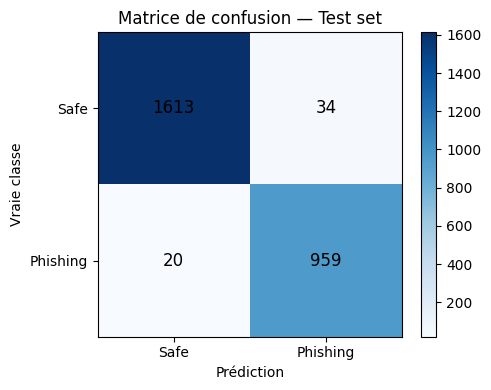

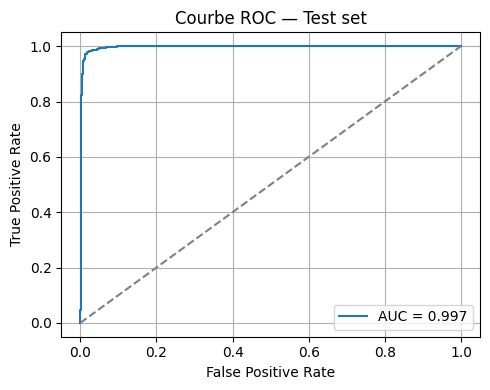

In [116]:
# Prediction sur le test set
y_test_pred = final_model.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Matrice de confusion — Test set")
plt.colorbar()

plt.xticks([0, 1], ["Safe", "Phishing"])
plt.yticks([0, 1], ["Safe", "Phishing"])

# Affichage des valeurs dans les cases
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="black", fontsize=12)

plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.tight_layout()
plt.show()

# ROC+AUC
# Probabilités de la classe positive (phishing)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
from sklearn import metrics as skm 
roc_auc = skm.auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC — Test set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Évaluation finale du modèle (Logistic Regression)

Le modèle de **Logistic Regression**, entraîné sur l’ensemble *train + validation*, a été évalué une seule fois sur le jeu de **test**, afin d’estimer sa capacité réelle de généralisation.

Les résultats obtenus montrent d’excellentes performances :

- **F1-score** : 0.973  
- **Precision** : 0.966  
- **Recall** : 0.980  
- **AUC** : 0.997  

La matrice de confusion indique un nombre très limité de faux négatifs, ce qui est particulièrement important dans un contexte de **détection de phishing**, où le coût d’un email frauduleux non détecté est élevé.

Ces résultats confirment que le modèle est à la fois **robuste, performant et bien généralisé**, tout en restant adapté à un déploiement en production grâce à la disponibilité de scores probabilistes nécessaires au monitoring et à l’interaction avec l’Agent IA.

Le modèle démontre une excellente capacité de discrimination sur le jeu de test,avec un taux de détection élevé des emails de phishing et un très faible nombre d’erreurs, confirmé par une AUC proche de 1.


### Interprétation des caractéristiques phishing

Cette analyse permet d’identifier les termes (mots ou n-grammes) qui contribuent le plus
à la prédiction de la classe *Phishing* dans le modèle de régression logistique.

Dans un modèle linéaire, chaque coefficient positif élevé indique que la présence du terme
augmente fortement la probabilité qu’un email soit classé comme phishing.

Les 20 termes affichés correspondent donc aux signaux lexicaux les plus discriminants
appris par le modèle à partir des données d’entraînement.

Cette étape est utile pour :
- comprendre le comportement du modèle,
- détecter une dépendance excessive à certains mots-clés,
- concevoir des jeux de données plus difficiles (hard negatives),
- évaluer la robustesse du modèle face à des emails plus réalistes.

In [117]:
# 1) Récupérer les poids du modèle LR (après fit)
clf = final_model.named_steps["clf"]
tfidf = final_model.named_steps["tfidf"]

coef = clf.coef_.ravel()  # shape (n_features,)
features = tfidf.get_feature_names_out()

# 2) Créer un tableau terme / poids
df_coef = pd.DataFrame({
    "term": features,
    "weight": coef
}).sort_values("weight", ascending=False)

# 3) Top signaux phishing (poids positifs)
top_phishing = df_coef.head(20)

# 4) Top signaux safe (poids négatifs)
top_safe = df_coef.tail(20).sort_values("weight", ascending=True)

print("Top 20 termes associés à 'Phishing' (poids positifs):")
display(top_phishing)

print("Top 20 termes associés à 'Safe' (poids négatifs):")
display(top_safe)


Top 20 termes associés à 'Phishing' (poids positifs):


,term,weight
29711,your,6.293720
29500,you,5.384190
18748,our,4.126736
12035,here,3.837549
16412,money,3.510413
852,2005,3.317203
10744,free,3.311746
17123,no,3.237255
6292,click here,3.141356
21222,remove,3.136683


Top 20 termes associés à 'Safe' (poids négatifs):


,term,weight
9208,enron,-7.082243
820,2002,-4.120807
24541,the,-3.939423
24386,thanks,-3.870088
29328,wrote,-3.517525
14574,language,-3.422575
18107,on,-3.380971
24405,that,-3.326941
28043,vince,-3.297757
795,2001,-3.110948


Les termes associés à la classe *Phishing* correspondent à des signaux lexicaux typiques des emails frauduleux, tels que des formulations directes à l’utilisateur (« your », « click here ») ou des incitations financières (« free », « money »).

À l’inverse, les termes associés à la classe *Safe* reflètent un contexte plus institutionnel ou académique (« university », « edu », « enron »), caractéristique des emails légitimes du jeu de données.

Ces résultats confirment que le modèle apprend des motifs linguistiques cohérents et interprétables, tout en soulignant une possible influence des sources de données sur certaines caractéristiques.


In [118]:
hard_samples = [
    # Phishing-like mais plus subtil (sans "click here", "free", "money")
    "We detected unusual activity on your account. Please verify your details to avoid suspension.",
    "Your mailbox storage is almost full. Confirm your settings to continue receiving messages.",

    # Safe-like mais avec vocabulaire proche (moins agressif que 'click here')
    "I have reviewed the document and added my comments in the shared file. We can discuss the remaining points during tomorrow's call.",
    "The seminar scheduled for Thursday has been moved to next week. Further details will be shared by the department."
]

# Appliquer le même nettoyage que pour l'entraînement
hard_samples_clean = [normalize_text(s) for s in hard_samples]

# Prédiction des classes (0 = safe, 1 = phishing)
hard_pred = final_model.predict(hard_samples_clean)

# Probabilité associée à la classe phishing (LR supporte predict_proba)
hard_proba = final_model.predict_proba(hard_samples_clean)[:, 1]

# Affichage des résultats
for text, y_hat, p in zip(hard_samples, hard_pred, hard_proba):
    label = "phishing" if y_hat == 1 else "safe"
    print("-" * 60)
    print(text)
    print(f"Pred: {label} | proba(phishing): {float(p):.3f}")


------------------------------------------------------------
We detected unusual activity on your account. Please verify your details to avoid suspension.
Pred: phishing | proba(phishing): 0.828
------------------------------------------------------------
Your mailbox storage is almost full. Confirm your settings to continue receiving messages.
Pred: phishing | proba(phishing): 0.734
------------------------------------------------------------
I have reviewed the document and added my comments in the shared file. We can discuss the remaining points during tomorrow's call.
Pred: safe | proba(phishing): 0.128
------------------------------------------------------------
The seminar scheduled for Thursday has been moved to next week. Further details will be shared by the department.
Pred: safe | proba(phishing): 0.194


### Analyse des hard samples
#### Limitation et interprétation du modèle

Le modèle **TF-IDF + Régression Logistique** apprend principalement des **corrélations lexicales**,
et non l’intention réelle de l’email.
Ainsi, des messages légitimes contenant un vocabulaire fréquemment associé au phishing
(par exemple des notifications de compte ou de service)
peuvent être classés à tort comme frauduleux.

En revanche, lorsque les exemples « safe » sont cohérents avec la définition implicite
du jeu de données — telles que des communications internes, académiques
ou purement informatives sans pression à l’action —
les prédictions du modèle deviennent plus cohérentes et interprétables.



In [119]:
# Sauvegarde des artefacts (modèle final + métriques)
# Le pipeline inclut TF-IDF + Logistic Regression

artifact_path = os.path.join(
    ARTIFACT_DIR,
    "phishing_tfidf_logreg.joblib"
)

joblib.dump(final_model, artifact_path)
print("Saved model:", artifact_path)

# Sauvegarde du TF-IDF seul (pour réutilisation stable dans le retrain)
tfidf_path = os.path.join(ARTIFACT_DIR, "tfidf_vectorizer.joblib")
tfidf_obj = final_model.named_steps["tfidf"]
joblib.dump(tfidf_obj, tfidf_path)
print("Saved TF-IDF vectorizer:", tfidf_path)

# Sauvegarde des métriques d’évaluation
metrics_path = os.path.join(ARTIFACT_DIR, "metrics.json")

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(
        {
            "validation": val_metrics,   # utilisé pour l’analyse / sélection
            "test": test_metrics         # performance finale reportée
        },
        f,
        ensure_ascii=False,
        indent=2
    )

print("Saved metrics:", metrics_path)


Saved model: ../artifacts\phishing_tfidf_logreg.joblib
Saved TF-IDF vectorizer: ../artifacts\tfidf_vectorizer.joblib
Saved metrics: ../artifacts\metrics.json


### Génération des données de référence (ref_data.csv) pour Evidently-ready

Cette étape consiste à transformer les textes du jeu de données en vecteurs TF-IDF à l’aide du
vectoriseur entraîné, puis à convertir ces représentations en un tableau de caractéristiques.

Le fichier `ref_data.csv` obtenu contient :
- les variables explicatives issues du TF-IDF,
- la variable cible (`target`).

Ces données servent de **référence** pour le monitoring du modèle après déploiement, notamment
pour la détection de *data drift* et de *model drift*.  

In [120]:
# 1) Extraire le TF-IDF depuis le pipeline final
tfidf: TfidfVectorizer = final_model.named_steps["tfidf"]

# 2) Données de référence = train + validation
X_ref_text = X_train_final
y_ref = y_train_final

# 3) Sous-échantillonnage
N_REF = 5000
rng = np.random.default_rng(RANDOM_SEED)
idx = rng.choice(len(X_ref_text), size=min(N_REF, len(X_ref_text)), replace=False)
X_ref_text = X_ref_text[idx]
y_ref = y_ref[idx]

# 4) TF-IDF sparse
X_ref_vec = tfidf.transform(X_ref_text)

# 5) Réduction de dimension (SVD) - IMPORTANT: fit on current TF-IDF output
N_COMPONENTS = 200
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_SEED)
X_ref_svd = svd.fit_transform(X_ref_vec)

# Sauvegarde de la SVD pour réutilisation (prod vectorisation + retrain)
svd_path = os.path.join(ARTIFACT_DIR, "svd_ref.joblib")
joblib.dump(svd, svd_path)

# 6) Export CSV léger
ref_df = pd.DataFrame(X_ref_svd, columns=[f"svd_{i}" for i in range(N_COMPONENTS)])
ref_df["target"] = y_ref

ref_path = os.path.join(DATA_OUT_DIR, "ref_data.csv")
ref_df.to_csv(ref_path, index=False)

print("Saved ref_data:", ref_path)
print("Saved SVD:", svd_path)
print("ref_data shape:", ref_df.shape)
print(f"SVD: {svd.n_features_in_} input features -> {svd.n_components} components")


Saved ref_data: ../data\ref_data.csv
Saved SVD: ../artifacts\svd_ref.joblib
ref_data shape: (5000, 201)
SVD: 30000 input features -> 200 components


In [122]:
# Validation rapide : charger le modèle et prédire un échantillon
loaded = joblib.load(os.path.join(ARTIFACT_DIR, "phishing_tfidf_logreg.joblib"))

sample_texts = [
    "Dear user, your account will be suspended, click here to verify immediately.",
    "Hello, here are the minutes from tomorrow's meeting. Thanks."
]

pred = loaded.predict(sample_texts)
proba = loaded.predict_proba(sample_texts)[:, 1]

for t, yhat, p in zip(sample_texts, pred, proba):
    print("-" * 60)
    print("TEXT:", t)
    print("PRED:", "phishing(1)" if yhat == 1 else "safe(0)")
    print("PROBA(phishing):", round(float(p), 4))


------------------------------------------------------------
TEXT: Dear user, your account will be suspended, click here to verify immediately.
PRED: phishing(1)
PROBA(phishing): 0.9017
------------------------------------------------------------
TEXT: Hello, here are the minutes from tomorrow's meeting. Thanks.
PRED: safe(0)
PROBA(phishing): 0.4937


## Synthèse – Partie 1 : Détection de mails/messages frauduleux

Dans cette première partie, nous avons développé un **modèle de détection de phishing** basé sur des données textuelles issues d’un corpus réel d’emails.

Après une phase de **nettoyage, normalisation et déduplication des textes**, le jeu de données a été séparé en ensembles *train / validation / test* (70 % / 15 % / 15 %), afin de garantir une évaluation rigoureuse et sans fuite de données.

Un modèle **TF-IDF + régression logistique** a été entraîné et comparé à d’autres approches linéaires. Bien que des performances similaires aient été observées avec un modèle SVM, la régression logistique a été retenue pour la suite du projet, car elle permet de produire des **probabilités de fraude**, essentielles pour l’interprétation, le monitoring et l’intégration métier.

Les performances obtenues sur le jeu de test sont élevées (F1-score et AUC proches de 1), ce qui s’explique en partie par la présence de **signaux lexicaux forts** caractéristiques des emails de phishing. L’analyse des coefficients du modèle confirme cette dépendance à certains motifs linguistiques, mettant en évidence la nécessité d’un **monitoring continu** et d’un **ré-entraînement périodique** en conditions réelles.

Enfin, les artefacts du modèle ainsi qu’un jeu de **données de référence vectorisées (`ref_data`)** ont été générés afin de servir de base aux étapes suivantes du projet : déploiement via API, surveillance des dérives (data/model drift) et automatisation du ré-entraînement.
